In [11]:
import pickle #read pickle file
import coffea
from coffea import hist
from topcoffea.modules.HistEFT import HistEFT
from coffea.analysis_tools import PackedSelection
import topcoffea.modules.eft_helper as efth
import gzip #read zipped pickle file
import matplotlib.pyplot as plt #plot histograms
from matplotlib.backends.backend_pdf import PdfPages
import topcoffea.modules.utils as utils
import mplhep as hep
import numpy as np
import awkward as ak
np.seterr(divide='ignore', invalid='ignore', over='ignore')

# import hist
# from hist import Hist

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
NanoAODSchema.warn_missing_crossrefs = False

In [55]:
hep.style.use("CMS")
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'legend.fontsize':20}
plt.rcParams.update(params)

wc_pts = {"ctGIm": 10.0, "ctGRe":10.0, "cQj38": 0.0, "cQj18": 0.0,
            "cQu8": 0.0, "cQd8": 0.0, "ctj8": 0.0, "ctu8": 0.0,
            "ctd8": 0.0, "cQj31": 0.0, "cQj11": 0.0, "cQu1": 0.0,
            "cQd1": 0.0, "ctj1": 0.0, "ctu1": 0.0, "ctd1": 0.0}

couplings = {'ctGIm': 0.7, 'ctGRe':0.7, 'cQj38':9.0, 'cQj18':7.0,
            'cQu8':9.5, 'cQd8':12.0, 'ctj8':7.0, 'ctu8':9.0,
            'ctd8':12.4, 'cQj31':3.0, 'cQj11':4.2, 'cQu1':5.5,
            'cQd1':7.0, 'ctj1':4.4, 'ctu1':5.4, 'ctd1':7.0}

In [3]:
# Clean the objects
def is_clean(obj_A, obj_B, drmin=0.4):
    objB_near, objB_DR = obj_A.nearest(obj_B, return_metric=True)
    mask = ak.fill_none(objB_DR > drmin, True)
    return (mask)

In [4]:
fname = "/project01/ndcms/hnelson2/ttbarEFT/nanoGen/LHCEFT/TT01j2l_ref_djr/nanoGen_401.root"
# fname = "/project01/ndcms/hnelson2/ttbarEFT/nanoGen/LHCEFT/TT01j2l_ref/nanoGen_1216.root"
# fname = "/project01/ndcms/hnelson2/mc_samples/central_UL/10C33CC0-846D-134B-99EA-F7E4200E9A48.root"
# fname = "/project01/ndcms/hnelson2/ttbarEFT/nanoGen/TT01j2l_S3/nanoGen_101.root"
# Load in events from root file
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema.v6,
    metadata={"dataset": "TT01j2l"},
).events()

In [5]:
wc_lst = utils.get_list_of_wc_names(fname)
print("wc list: ", wc_lst)

dataset = events.metadata['dataset']

wc list:  ['cQd1', 'ctj1', 'cQj31', 'ctj8', 'ctd1', 'ctd8', 'ctGRe', 'ctGIm', 'cQj11', 'cQj18', 'ctu8', 'cQd8', 'ctu1', 'cQu1', 'cQj38', 'cQu8']


In [6]:
# Extract the EFT quadratic coefficients and optionally use them to calculate the coefficients on the w**2 quartic function
# eft_coeffs is never Jagged so convert immediately to numpy for ease of use.
eft_coeffs = ak.to_numpy(events['EFTfitCoefficients']) if hasattr(events, "EFTfitCoefficients") else None

In [7]:
if eft_coeffs is None:
    event_weights = events["genWeight"]
else:
    event_weights = np.ones_like(events['event'])

In [10]:
######## Initialize objects  ########

genpart = events.GenPart
is_final_mask = genpart.hasFlags(["fromHardProcess","isLastCopy"])
ele  = genpart[is_final_mask & (abs(genpart.pdgId) == 11)]
mu   = genpart[is_final_mask & (abs(genpart.pdgId) == 13)]
jets = events.GenJet


######## Lep selection  ########

e_selec = ((ele.pt>20) & (abs(ele.eta)<2.5))
m_selec = ((mu.pt>20) & (abs(mu.eta)<2.5))
leps = ak.concatenate([ele[e_selec],mu[m_selec]],axis=1)
leps = leps[ak.argsort(leps.pt, axis=-1, ascending=False)]


######## Jet selection  ########

jets = jets[(jets.pt>30) & (abs(jets.eta)<2.5)]
jets_clean = jets[is_clean(jets, leps, drmin=0.4)]

In [12]:
######## Event selections ########

nleps = ak.num(leps)
njets = ak.num(jets_clean)

at_least_two_leps = ak.fill_none(nleps>=2,False)
at_least_two_jets = ak.fill_none(njets>=2, False)

selections = PackedSelection()
selections.add('2l', at_least_two_leps)
selections.add('2j', at_least_two_jets)
event_selection_mask = selections.all('2l', '2j')

In [13]:
if eft_coeffs is None:
    genw = events["genWeight"]
else:
    genw = np.ones_like(events['event'])

In [62]:
# Jet Flavor
jet_flav = abs(jets_clean[event_selection_mask].partonFlavour)
njets = ak.num(jets_clean[event_selection_mask])
jet_flav_eft = np.repeat(eft_coeffs[event_selection_mask], njets, axis=0)
jet_flav_weight = np.repeat(event_weights[event_selection_mask], njets, axis=0)

In [67]:
histos = {
    "jet_flav" : HistEFT("Events", wc_lst, hist.Cat("sample", "sample"), hist.Bin("jet_flav", "pdgID jet flavor", 23, 0, 23)),
}

In [68]:
jet_flav_fill_info = {
    "jet_flav": ak.flatten(jet_flav), 
    "sample": dataset,
    "weight": jet_flav_weight, 
    "eft_coeff": jet_flav_eft,
}

In [69]:
histos["jet_flav"].fill(**jet_flav_fill_info)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


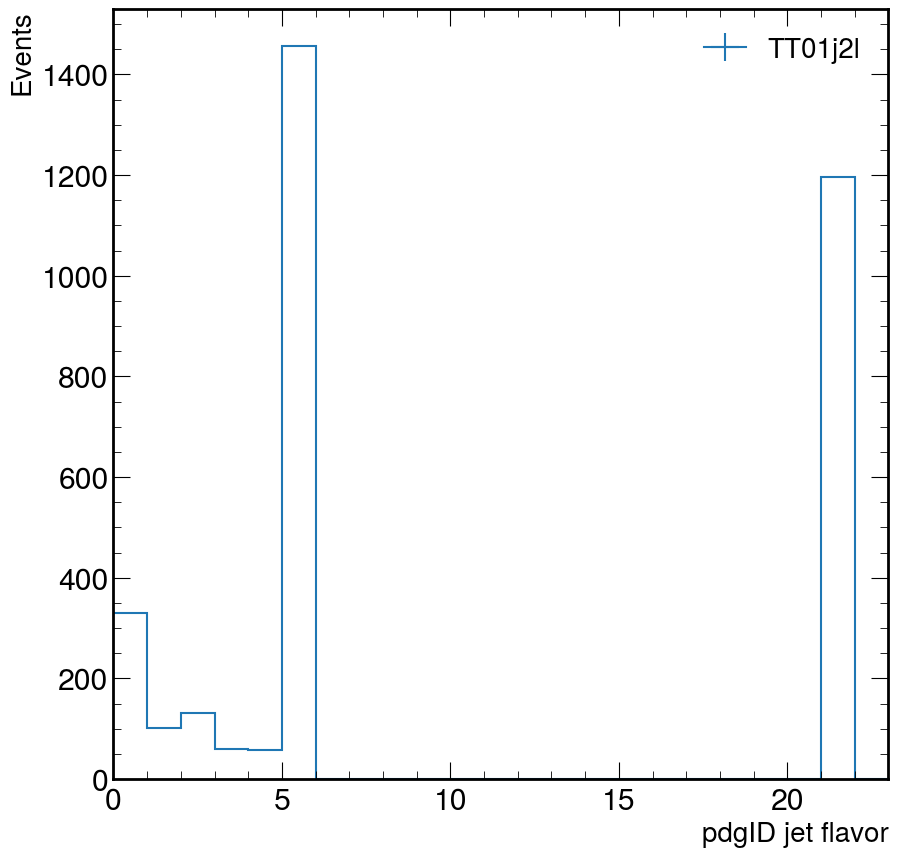

In [73]:
h = histos['jet_flav']
h.set_sm()
# print(h._wcs)
# h.set_wilson_coefficients(**couplings)
print(h._wcs)
fig, ax = plt.subplots(1,1)
hist.plot1d(h, ax=ax, stack=False)
ax.legend()